# Kidnapped Vehicle Project


## Visualisation

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.animation as manimation
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np

In [3]:
def transform_observation(p_x, p_y, p_theta, o_x, o_y):
    #(o_y, o_x) = (o_x, o_y)
    x = o_x * np.cos(p_theta) - o_y * np.sin(p_theta) + p_x
    y = o_x * np.sin(p_theta) + o_y * np.cos(p_theta) + p_y
    return (x,y)

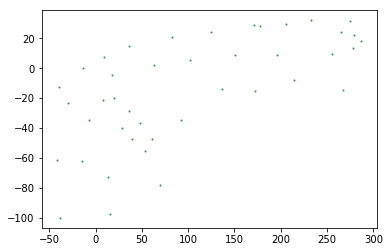

In [4]:
def read_landmarks():
    return pd.read_table('../data/map_data.txt', sep='\s+', names=['x', 'y', 'id'])

def plot_landmarks(landmarks):
    plt.scatter(landmarks['x'], landmarks['y'], marker='o', color='C2', s=1)

LANDMARKS = read_landmarks()
plot_landmarks(LANDMARKS)

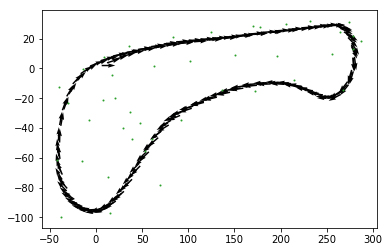

In [5]:
def read_ground_truth():
    return pd.read_table('../data/gt_data.txt', sep='\s+', names=['x', 'y', 'theta'])

def plot_quiver(ground_truth, **kwargs):
    u = np.cos(ground_truth['theta'])
    v = np.sin(ground_truth['theta'])
    plt.quiver(ground_truth['x'], ground_truth['y'], u, v, **kwargs)
    
GROUND_TRUTH = read_ground_truth()
plot_quiver(GROUND_TRUTH.iloc[0::13])
plot_landmarks(LANDMARKS)

In [6]:
# The trace just prints x y theta w, one line per update.
def read_trace():
    time = 0
    frames = []
    
    for step in range(0, 2333):
        with open ('../data/particles/particles_'+str(step)+'.txt') as f:
            p_df = pd.read_table(f, sep=' ', header=None, names=['x','y','theta', 'weight'], lineterminator='\n')
        times = np.ones(p_df.shape[0]) * time
        p_df['t'] = pd.Series(times, index=p_df.index)
        p_df = p_df[['t','x','y','theta', 'weight']]
        frames.append(p_df)
        time += 1
    return pd.concat(frames)
    
TRACE = read_trace()
TRACE.head()

,t,x,y,theta,weight
0,0.0,6.54820,2.12673,-0.006539,0.000047
1,0.0,6.23796,1.96125,0.008915,0.000600
2,0.0,6.23796,1.96125,0.008915,0.000600
3,0.0,6.23796,1.96125,0.008915,0.000600
4,0.0,6.23796,1.96125,0.008915,0.000600


In [7]:
def read_observations():
    time = 0
    frames = []
    
    for step in range(1, 2333):
        with open ('../data/observation/observations_%06d.txt' % step) as f:
            p_df = pd.read_table(f, sep=' ', header=None, names=['x','y'], lineterminator='\n')
        times = np.ones(p_df.shape[0]) * time
        p_df['t'] = pd.Series(times, index=p_df.index)
        p_df = p_df[['t','x','y']]
        frames.append(p_df)
        time += 1
    return pd.concat(frames)

def plot_observations(ground_truth, observations, **kwargs):
    gt_x = ground_truth['x']
    gt_y = ground_truth['y']
    gt_theta = ground_truth['theta']
    obs_x = observations['x']
    obs_y = observations['y']
    tr_obs_x, tr_obs_y = transform_observation(gt_x, gt_y, gt_theta, obs_x, obs_y)
    
    gt_x_list = (np.ones_like(tr_obs_x) * gt_x).tolist()
    gt_y_list = (np.ones_like(tr_obs_y) * gt_y).tolist()
    gt = zip(gt_x_list, gt_y_list)
    tr_obs = zip(tr_obs_x.tolist(), tr_obs_y.tolist())
    lines = zip(gt, tr_obs)
    lc = mc.LineCollection(lines, **kwargs)
    plt.gca().add_collection(lc)

OBSRV = read_observations()
OBSRV.head()

,t,x,y
0,0.0,2.4853,5.6048
1,0.0,11.1420,-6.5591
2,0.0,-19.9200,-2.0582
3,0.0,1.9234,-22.9300
4,0.0,13.8610,-22.1100


In [8]:
def plot_trace(trace, observations, size=720, arrow_scale=100, step=1):
    FFMPEGWriter = manimation.writers['ffmpeg']
    writer = FFMPEGWriter(fps=10)

    fig = plt.figure()
    pad = 50
    plt.xlim(np.min(GROUND_TRUTH['x']) - pad, np.max(GROUND_TRUTH['x']) + pad)
    plt.ylim(np.min(GROUND_TRUTH['y']) - pad, np.max(GROUND_TRUTH['y']) + pad)
    
    end_time = int(np.max(trace['t']))
    with writer.saving(fig, "../data/trace.mp4", size):
        for time in range(0, end_time, step):
            trace_time = trace.loc[trace['t'] == time]
            obs_time = observations.loc[observations['t'] == time]
            gt = GROUND_TRUTH.loc[time]
            
            # Plot big picture
            plt.xlim(-60,310)
            plt.ylim(-110,35)
            plot_landmarks(LANDMARKS)
            plot_observations(gt, obs_time, linewidths=0.05, colors='k', linestyle='dotted')
            plot_quiver(trace_time, width=0.002, scale=arrow_scale / 2, color='r')
            plot_quiver(gt,         width=0.002, scale=arrow_scale / 2)
            
            # Plot small picture
            plt.axes([.55, .25, .3, .2])
            plt.xlim(gt['x'] - pad / 2, gt['x'] + pad / 2)
            plt.ylim(gt['y'] - pad / 2, gt['y'] + pad / 2)
            plot_landmarks(LANDMARKS)
            plot_observations(gt, obs_time, linewidths=0.1, colors='k', linestyle='dotted')            
            plot_quiver(trace_time, width=0.01, scale=arrow_scale / 10, color='r')
            plot_quiver(gt,         width=0.01, scale=arrow_scale / 10)

            writer.grab_frame()
            plt.clf()
            
plot_trace(TRACE, OBSRV)